In [132]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

path = 'kaggle/input'
# path = '/kaggle/input'

for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        print(os.path.join(dirname, filename))

kaggle/input\holidays_events.csv
kaggle/input\oil.csv
kaggle/input\sample_submission.csv
kaggle/input\stores.csv
kaggle/input\test.csv
kaggle/input\train.csv
kaggle/input\transactions.csv


In [133]:
train = pd.read_csv(os.path.join(path, 'train.csv'))
train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [134]:
stores = pd.read_csv(os.path.join(path, 'stores.csv'))
stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [135]:
print(f'store_nbr: {np.sort(train['store_nbr'].unique())}\n')

print(f'family: {np.sort(train['family'].unique())}\n')

print(f'cluster: {np.sort(stores['cluster'].unique())}\n')

store_nbr: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54]

family: ['AUTOMOTIVE' 'BABY CARE' 'BEAUTY' 'BEVERAGES' 'BOOKS' 'BREAD/BAKERY'
 'CELEBRATION' 'CLEANING' 'DAIRY' 'DELI' 'EGGS' 'FROZEN FOODS' 'GROCERY I'
 'GROCERY II' 'HARDWARE' 'HOME AND KITCHEN I' 'HOME AND KITCHEN II'
 'HOME APPLIANCES' 'HOME CARE' 'LADIESWEAR' 'LAWN AND GARDEN' 'LINGERIE'
 'LIQUOR,WINE,BEER' 'MAGAZINES' 'MEATS' 'PERSONAL CARE' 'PET SUPPLIES'
 'PLAYERS AND ELECTRONICS' 'POULTRY' 'PREPARED FOODS' 'PRODUCE'
 'SCHOOL AND OFFICE SUPPLIES' 'SEAFOOD']

cluster: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]



In [159]:
oil = pd.read_csv(os.path.join(path, 'oil.csv'))
oil['date'] = pd.to_datetime(oil['date'])
oil['dcoilwtico'] = oil['dcoilwtico'].ffill()
oil['dcoilwtico'] = oil['dcoilwtico'].bfill()
oil.head()

,date,dcoilwtico
0,2013-01-01,93.14
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [138]:
holiday_events = pd.read_csv(os.path.join(path, 'holidays_events.csv'))

holiday_events = holiday_events[holiday_events['transferred'] == False]
holiday_events['holiday'] = 1
holiday_events.head()

,date,type,locale,locale_name,description,transferred,holiday
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False,1
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False,1
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False,1
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False,1
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False,1


In [140]:
# x = preprocess(train)
x = train.copy()
x = x.merge(stores[['store_nbr', 'city', 'state']], on='store_nbr', how='left')
x = get_oil(x)
x = get_holiday(x)
# x.sample(1000, random_state=42).to_csv('train_preprocessed.csv', index=False)

In [141]:
combos = x[['store_nbr', 'family']].drop_duplicates().reset_index(drop=True)

combo_sample = x.merge(combos.sample(10, random_state=42), on=['store_nbr', 'family'], how='inner')

combo_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16840 entries, 0 to 16839
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           16840 non-null  int64  
 1   date         16840 non-null  object 
 2   store_nbr    16840 non-null  int64  
 3   family       16840 non-null  object 
 4   sales        16840 non-null  float64
 5   onpromotion  16840 non-null  int64  
 6   city         16840 non-null  object 
 7   state        16840 non-null  object 
 8   dcoilwtico   16840 non-null  float64
 9   holiday      16840 non-null  int32  
dtypes: float64(2), int32(1), int64(3), object(4)
memory usage: 1.2+ MB


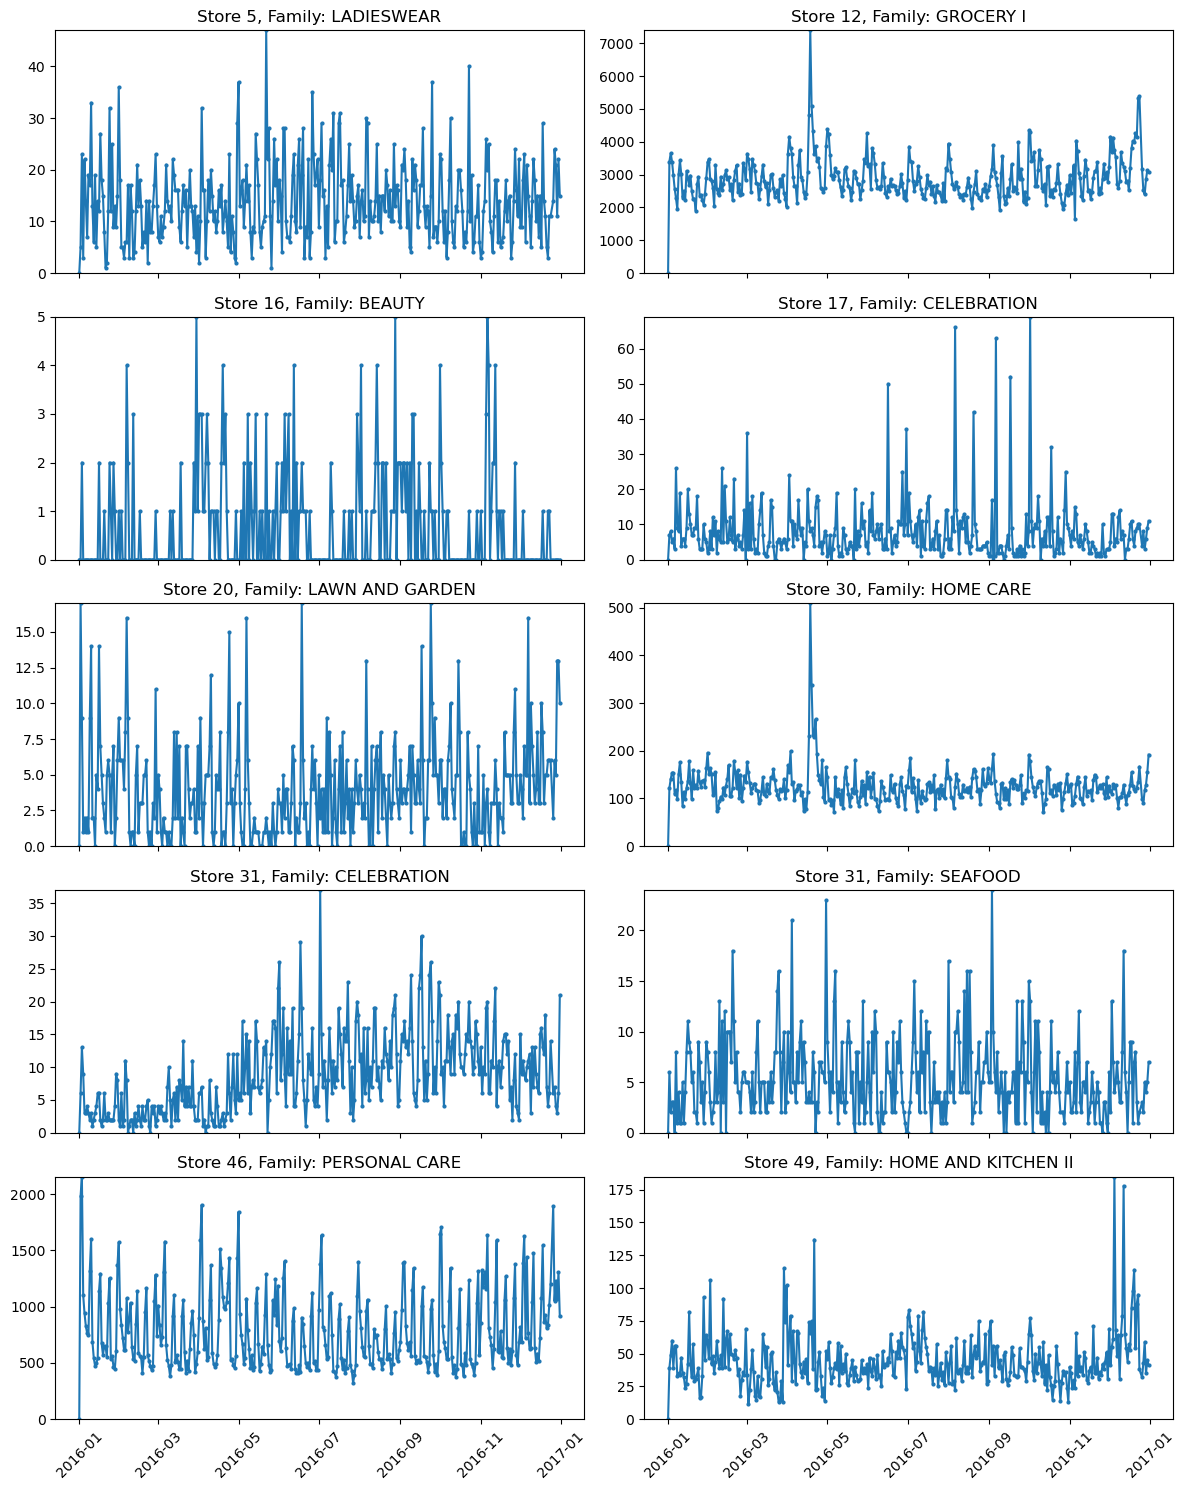

In [142]:
combo_sample['date'] = pd.to_datetime(combo_sample['date'])
combo_sample = combo_sample[combo_sample['date'].dt.year == 2016]
groups = combo_sample.groupby(['store_nbr', 'family'])

fig, axs = plt.subplots(5, 2, figsize=(12, 15), sharex=True)
axs = axs.flatten()

for ax, ((store_nbr, family), group) in zip(axs, groups):
    group = group.sort_values('date')
    ax.plot(group['date'], group['sales'], marker='o', markersize=2)
    ax.set_title(f'Store {store_nbr}, Family: {family}')
    ax.tick_params(axis='x', rotation=45)
    ax.set_ylim(group['sales'].min(), group['sales'].max())

plt.tight_layout()
plt.show()

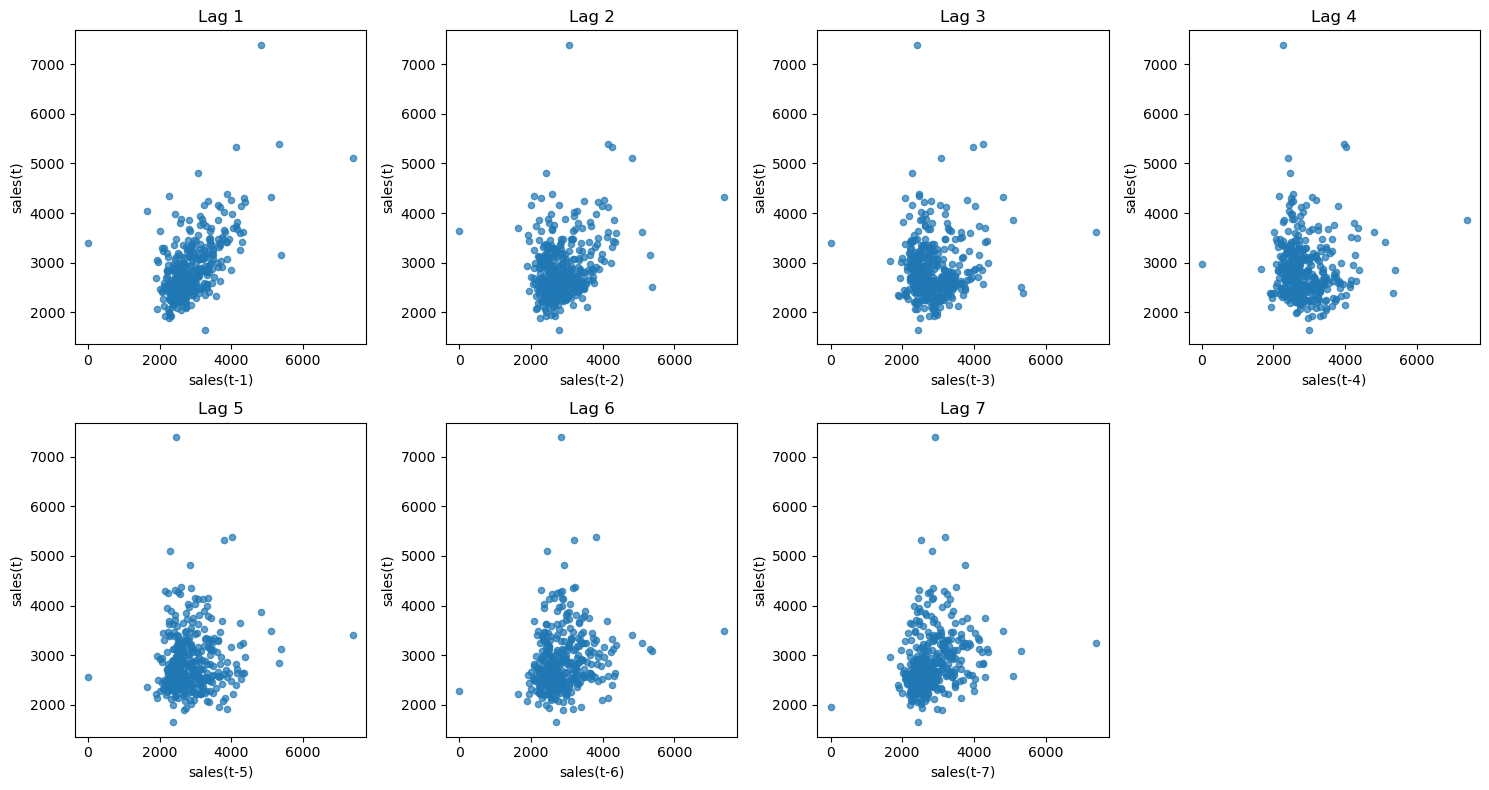

In [143]:
# Get the first group from the groups object and sort by date
first_key, first_group = list(groups)[1]
first_group = first_group.sort_values('date')
sales = first_group['sales'].reset_index(drop=True)

# Create lag plots for lags 1 through 7
fig, axes = plt.subplots(2, 4, figsize=(15, 8))
axes = axes.flatten()

for lag in range(1, 8): 
    shifted = sales.shift(lag)
    # Ensure we only compare valid (non-NaN) points
    valid = shifted.notna()
    axes[lag - 1].scatter(shifted[valid], sales[valid], s=20, alpha=0.7)
    axes[lag - 1].set_title(f'Lag {lag}')
    axes[lag - 1].set_xlabel(f'sales(t-{lag})')
    axes[lag - 1].set_ylabel('sales(t)')

# Disable the unused subplot
axes[-1].axis('off')

plt.tight_layout()
plt.show()

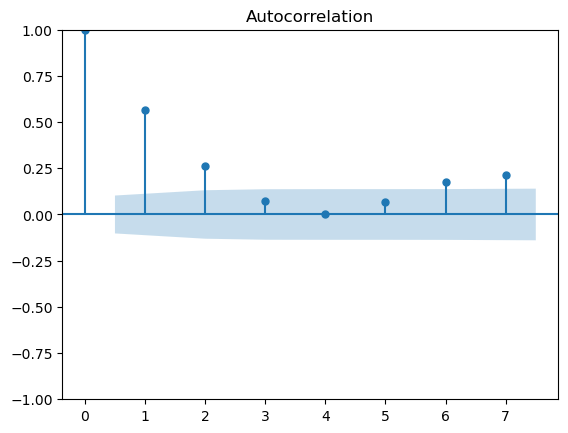

In [144]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(sales, lags=7)
plt.show()

In [145]:
# Source: https://www.kaggle.com/code/ryanholbrook/seasonality

def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("365D") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

<Axes: title={'center': 'Periodogram'}, ylabel='Variance'>

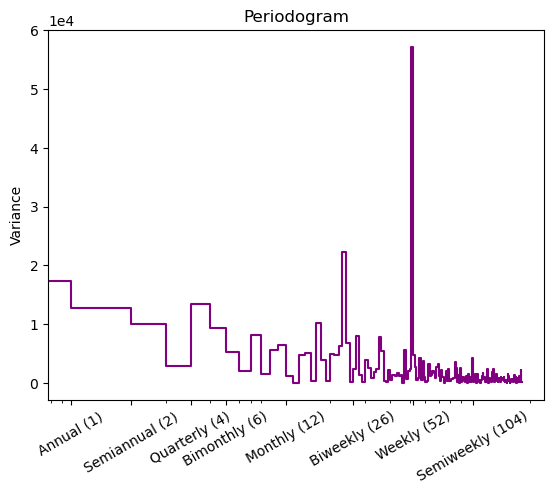

In [146]:
plot_periodogram(sales)

In [175]:
from statsmodels.tsa.deterministic import DeterministicProcess, CalendarFourier

def get_location(df):
    df = df.merge(stores[['store_nbr', 'state', 'city']], on='store_nbr', how='left')
    
    return df

def get_oil(df):
    df = df.merge(oil[['date', 'dcoilwtico']], on='date', how='left')
    
    df['dcoilwtico'] = df['dcoilwtico'].ffill()
    df['dcoilwtico'] = df['dcoilwtico'].bfill()
    
    return df

def get_holiday(df):
    df = df.merge(holiday_events[holiday_events['type'] == 'National'][['date', 'holiday']], on='date', how='left')
    df = df.merge(holiday_events[holiday_events['type'] == 'Regional'][['date', 'locale_name', 'holiday']], left_on=['date', 'state'], right_on=['date', 'locale_name'], how='left')
    df = df.merge(holiday_events[holiday_events['type'] == 'Local'][['date', 'locale_name', 'holiday']], left_on=['date', 'city'], right_on=['date', 'locale_name'], how='left')
    
    df['holiday'] = df['holiday'] | df['holiday_y'] | df['holiday_x']
    df = df.drop(columns=['holiday_x', 'holiday_y', 'locale_name_x', 'locale_name_y'])
    df['holiday'] = df['holiday'].fillna(0).astype(int)
    
    return df

def get_seasonality(df, order=1):
    uniq_idx = pd.date_range(df['date'].min(),
                            df['date'].max(),
                            freq='D')

    fourier = CalendarFourier(freq='YE', order=order)

    dp = DeterministicProcess(
        index= uniq_idx,
        order = 0,
        constant = False,
        seasonal = True,
        additional_terms = [fourier],
        drop = False
    )

    det_feats = dp.in_sample()

    df = df.merge(det_feats, left_on='date', right_index=True, how='left')

    return df

def get_lags(df, lags = [1]):
    for lag in lags:
        df[f'sales_lag_{lag}'] = df.groupby(['store_nbr', 'family'])['sales'].shift(lag)
    
    return df


def preprocess(df):
    df = df.copy()
    df['date'] = pd.to_datetime(df['date'])

    df = get_location(df)
    df = get_oil(df)
    df = get_holiday(df)
    df = get_seasonality(df, order=4)
    df = get_lags(df, lags=[1, 7])

    df = df.drop(columns=['state', 'city'])
    df = df.dropna(subset=['sales', 'sales_lag_1', 'sales_lag_7'])

    df = df.set_index(['id'])

    return df

In [176]:
train_x = preprocess(train)
train_x.info()

train_x.sample(10000, random_state=42).to_csv('train_preprocessed.csv', index=True)

<class 'pandas.core.frame.DataFrame'>
Index: 2988414 entries, 12474 to 3000887
Data columns (total 24 columns):
 #   Column              Dtype         
---  ------              -----         
 0   date                datetime64[ns]
 1   store_nbr           int64         
 2   family              object        
 3   sales               float64       
 4   onpromotion         int64         
 5   dcoilwtico          float64       
 6   holiday             int32         
 7   s(1,7)              float64       
 8   s(2,7)              float64       
 9   s(3,7)              float64       
 10  s(4,7)              float64       
 11  s(5,7)              float64       
 12  s(6,7)              float64       
 13  s(7,7)              float64       
 14  sin(1,freq=YE-DEC)  float64       
 15  cos(1,freq=YE-DEC)  float64       
 16  sin(2,freq=YE-DEC)  float64       
 17  cos(2,freq=YE-DEC)  float64       
 18  sin(3,freq=YE-DEC)  float64       
 19  cos(3,freq=YE-DEC)  float64       
 20  sin